In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


In [2]:
## Sensory anticipation module (SAM) implementation

### Description of the SAM

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

Core functions for the SAM are implemented below.

In [12]:
'''
Dictionary of network parameters,
Wut, Wuv, Wvt, Wvu: weights of connections
dt: interval of, in ms
tau: time constant, in ms
y0: threshold of SAM
IF: input used for reset
uinit, vinit, yinit: initial state of u, v and y
first_duration: duration of first interval before first flash, in ms
'''
# Original value: u = 0.7, v = 0.2
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.3,
              'yinit': 0.5,
              'first_duration': 750}

In [13]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters of the network, see PARAMS_DICT
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [14]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [40]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials, duration, nstages, sigma, K, initI):
    # Initial run
    first_duration = PARAMS_DICT['first_duration'] #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']
    print('uinit =', uinit, 'vinit =', vinit)

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        #print('k = ', k, 'state_init[4] =', state_init[4])
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        
        if nstages == 2:
            Keff = 0
        else:
            Keff = K
        
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, Keff, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2


def get_time_lst(ntrials, duration, nstages, sigma, K, initI):
    '''Simulate and return the array of times of threshold crossing'''
    _, _, _, _, _, ylst2 = simulate_trial(ntrials=ntrials, nstages=nstages, duration=duration, 
                                                                       sigma=sigma, K=K, initI=initI)
    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    return times

## SAM simulations

We examine the behavior of the SAM (Figure 3)

uinit = 0.7 vinit = 0.3
Mean tp =  43.123333333333335 std tp =  1.1610866557764852


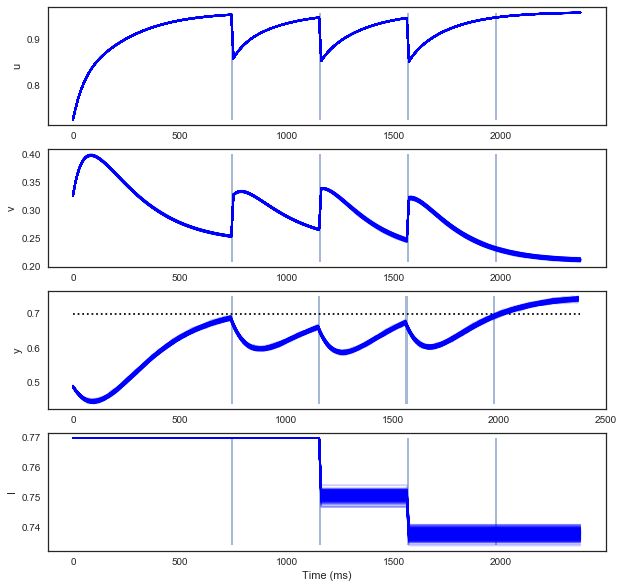

In [41]:
# Figure 3a
sigma = 0.01
I = 0.77
K = 5.0
duration = 400

np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=4, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean tp = ', np.mean(times), 'std tp = ', np.std(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data020819_K5_00_I0_77_s0_01_400ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

In [84]:
# Supp figure 1 - dependence on initial values of u and v
sigma = 0.01
I = 0.77
K = 5.0
duration = 400

PARAMS_DICT['vinit'] = 0.2

vinit_lst = np.linspace(0, 0.6, 30)
uinit_lst = np.linspace(0.3, 1.5, 40)
np.random.seed(2018)
means = np.zeros((len(uinit_lst), len(vinit_lst)))
stds = np.zeros((len(uinit_lst), len(vinit_lst)))

for idu, uinit in enumerate(uinit_lst):
    for idv, vinit in enumerate(vinit_lst):
        PARAMS_DICT['uinit'] = uinit
        PARAMS_DICT['vinit'] = vinit
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=4, duration=duration, sigma=sigma, 
                                                               K=K, initI=I)
        #plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

        Ylst2 = np.array(ylst2)
        times = get_times_lst_from_y(np.array(Ylst2))
        times = times[(times > 0) & (times != np.inf)]
        #print('Mean tp = ', np.mean(times), 'std tp = ', np.std(times))
        means[idu][idv] = np.mean(times)
        stds[idu][idv] = np.std(times)
    
#plt.errorbar(uinit_lst, means, stds)
scipy.io.savemat('uv_init_times_v_0to0.6_u_0.3to1.5_fine.mat', {'vinit_lst': vinit_lst, 'uinit_lst': uinit_lst,
                                                      'means': means, 'stds': stds})

uinit = 0.3 vinit = 0.0
uinit = 0.3 vinit = 0.020689655172413793
uinit = 0.3 vinit = 0.041379310344827586
uinit = 0.3 vinit = 0.06206896551724138
uinit = 0.3 vinit = 0.08275862068965517
uinit = 0.3 vinit = 0.10344827586206896
uinit = 0.3 vinit = 0.12413793103448276
uinit = 0.3 vinit = 0.14482758620689656
uinit = 0.3 vinit = 0.16551724137931034
uinit = 0.3 vinit = 0.18620689655172412
uinit = 0.3 vinit = 0.20689655172413793
uinit = 0.3 vinit = 0.22758620689655173
uinit = 0.3 vinit = 0.2482758620689655
uinit = 0.3 vinit = 0.2689655172413793
uinit = 0.3 vinit = 0.2896551724137931
uinit = 0.3 vinit = 0.3103448275862069
uinit = 0.3 vinit = 0.3310344827586207
uinit = 0.3 vinit = 0.35172413793103446
uinit = 0.3 vinit = 0.37241379310344824
uinit = 0.3 vinit = 0.3931034482758621
uinit = 0.3 vinit = 0.41379310344827586
uinit = 0.3 vinit = 0.43448275862068964
uinit = 0.3 vinit = 0.45517241379310347
uinit = 0.3 vinit = 0.47586206896551725


C:\Users\Le\Anaconda3b\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Le\Anaconda3b\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Le\Anaconda3b\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Le\Anaconda3b\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Le\Anaconda3b\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


uinit = 0.3 vinit = 0.496551724137931
uinit = 0.3 vinit = 0.5172413793103449
uinit = 0.3 vinit = 0.5379310344827586
uinit = 0.3 vinit = 0.5586206896551724
uinit = 0.3 vinit = 0.5793103448275863
uinit = 0.3 vinit = 0.6
uinit = 0.33076923076923076 vinit = 0.0
uinit = 0.33076923076923076 vinit = 0.020689655172413793
uinit = 0.33076923076923076 vinit = 0.041379310344827586
uinit = 0.33076923076923076 vinit = 0.06206896551724138
uinit = 0.33076923076923076 vinit = 0.08275862068965517
uinit = 0.33076923076923076 vinit = 0.10344827586206896
uinit = 0.33076923076923076 vinit = 0.12413793103448276
uinit = 0.33076923076923076 vinit = 0.14482758620689656
uinit = 0.33076923076923076 vinit = 0.16551724137931034
uinit = 0.33076923076923076 vinit = 0.18620689655172412
uinit = 0.33076923076923076 vinit = 0.20689655172413793
uinit = 0.33076923076923076 vinit = 0.22758620689655173
uinit = 0.33076923076923076 vinit = 0.2482758620689655
uinit = 0.33076923076923076 vinit = 0.2689655172413793
uinit = 0.3307

uinit = 0.48461538461538456 vinit = 0.08275862068965517
uinit = 0.48461538461538456 vinit = 0.10344827586206896
uinit = 0.48461538461538456 vinit = 0.12413793103448276
uinit = 0.48461538461538456 vinit = 0.14482758620689656
uinit = 0.48461538461538456 vinit = 0.16551724137931034
uinit = 0.48461538461538456 vinit = 0.18620689655172412
uinit = 0.48461538461538456 vinit = 0.20689655172413793
uinit = 0.48461538461538456 vinit = 0.22758620689655173
uinit = 0.48461538461538456 vinit = 0.2482758620689655
uinit = 0.48461538461538456 vinit = 0.2689655172413793
uinit = 0.48461538461538456 vinit = 0.2896551724137931
uinit = 0.48461538461538456 vinit = 0.3103448275862069
uinit = 0.48461538461538456 vinit = 0.3310344827586207
uinit = 0.48461538461538456 vinit = 0.35172413793103446
uinit = 0.48461538461538456 vinit = 0.37241379310344824
uinit = 0.48461538461538456 vinit = 0.3931034482758621
uinit = 0.48461538461538456 vinit = 0.41379310344827586
uinit = 0.48461538461538456 vinit = 0.4344827586206896

uinit = 0.6384615384615384 vinit = 0.16551724137931034
uinit = 0.6384615384615384 vinit = 0.18620689655172412
uinit = 0.6384615384615384 vinit = 0.20689655172413793
uinit = 0.6384615384615384 vinit = 0.22758620689655173
uinit = 0.6384615384615384 vinit = 0.2482758620689655
uinit = 0.6384615384615384 vinit = 0.2689655172413793
uinit = 0.6384615384615384 vinit = 0.2896551724137931
uinit = 0.6384615384615384 vinit = 0.3103448275862069
uinit = 0.6384615384615384 vinit = 0.3310344827586207
uinit = 0.6384615384615384 vinit = 0.35172413793103446
uinit = 0.6384615384615384 vinit = 0.37241379310344824
uinit = 0.6384615384615384 vinit = 0.3931034482758621
uinit = 0.6384615384615384 vinit = 0.41379310344827586
uinit = 0.6384615384615384 vinit = 0.43448275862068964
uinit = 0.6384615384615384 vinit = 0.45517241379310347
uinit = 0.6384615384615384 vinit = 0.47586206896551725
uinit = 0.6384615384615384 vinit = 0.496551724137931
uinit = 0.6384615384615384 vinit = 0.5172413793103449
uinit = 0.638461538

uinit = 0.7923076923076923 vinit = 0.496551724137931
uinit = 0.7923076923076923 vinit = 0.5172413793103449
uinit = 0.7923076923076923 vinit = 0.5379310344827586
uinit = 0.7923076923076923 vinit = 0.5586206896551724
uinit = 0.7923076923076923 vinit = 0.5793103448275863
uinit = 0.7923076923076923 vinit = 0.6
uinit = 0.823076923076923 vinit = 0.0
uinit = 0.823076923076923 vinit = 0.020689655172413793
uinit = 0.823076923076923 vinit = 0.041379310344827586
uinit = 0.823076923076923 vinit = 0.06206896551724138
uinit = 0.823076923076923 vinit = 0.08275862068965517
uinit = 0.823076923076923 vinit = 0.10344827586206896
uinit = 0.823076923076923 vinit = 0.12413793103448276
uinit = 0.823076923076923 vinit = 0.14482758620689656
uinit = 0.823076923076923 vinit = 0.16551724137931034
uinit = 0.823076923076923 vinit = 0.18620689655172412
uinit = 0.823076923076923 vinit = 0.20689655172413793
uinit = 0.823076923076923 vinit = 0.22758620689655173
uinit = 0.823076923076923 vinit = 0.2482758620689655
uinit

uinit = 0.9461538461538461 vinit = 0.6
uinit = 0.9769230769230768 vinit = 0.0
uinit = 0.9769230769230768 vinit = 0.020689655172413793
uinit = 0.9769230769230768 vinit = 0.041379310344827586
uinit = 0.9769230769230768 vinit = 0.06206896551724138
uinit = 0.9769230769230768 vinit = 0.08275862068965517
uinit = 0.9769230769230768 vinit = 0.10344827586206896
uinit = 0.9769230769230768 vinit = 0.12413793103448276
uinit = 0.9769230769230768 vinit = 0.14482758620689656
uinit = 0.9769230769230768 vinit = 0.16551724137931034
uinit = 0.9769230769230768 vinit = 0.18620689655172412
uinit = 0.9769230769230768 vinit = 0.20689655172413793
uinit = 0.9769230769230768 vinit = 0.22758620689655173
uinit = 0.9769230769230768 vinit = 0.2482758620689655
uinit = 0.9769230769230768 vinit = 0.2689655172413793
uinit = 0.9769230769230768 vinit = 0.2896551724137931
uinit = 0.9769230769230768 vinit = 0.3103448275862069
uinit = 0.9769230769230768 vinit = 0.3310344827586207
uinit = 0.9769230769230768 vinit = 0.35172413

uinit = 1.1307692307692307 vinit = 0.12413793103448276
uinit = 1.1307692307692307 vinit = 0.14482758620689656
uinit = 1.1307692307692307 vinit = 0.16551724137931034
uinit = 1.1307692307692307 vinit = 0.18620689655172412
uinit = 1.1307692307692307 vinit = 0.20689655172413793
uinit = 1.1307692307692307 vinit = 0.22758620689655173
uinit = 1.1307692307692307 vinit = 0.2482758620689655
uinit = 1.1307692307692307 vinit = 0.2689655172413793
uinit = 1.1307692307692307 vinit = 0.2896551724137931
uinit = 1.1307692307692307 vinit = 0.3103448275862069
uinit = 1.1307692307692307 vinit = 0.3310344827586207
uinit = 1.1307692307692307 vinit = 0.35172413793103446
uinit = 1.1307692307692307 vinit = 0.37241379310344824
uinit = 1.1307692307692307 vinit = 0.3931034482758621
uinit = 1.1307692307692307 vinit = 0.41379310344827586
uinit = 1.1307692307692307 vinit = 0.43448275862068964
uinit = 1.1307692307692307 vinit = 0.45517241379310347
uinit = 1.1307692307692307 vinit = 0.47586206896551725
uinit = 1.130769

uinit = 1.2846153846153845 vinit = 0.2689655172413793
uinit = 1.2846153846153845 vinit = 0.2896551724137931
uinit = 1.2846153846153845 vinit = 0.3103448275862069
uinit = 1.2846153846153845 vinit = 0.3310344827586207
uinit = 1.2846153846153845 vinit = 0.35172413793103446
uinit = 1.2846153846153845 vinit = 0.37241379310344824
uinit = 1.2846153846153845 vinit = 0.3931034482758621
uinit = 1.2846153846153845 vinit = 0.41379310344827586
uinit = 1.2846153846153845 vinit = 0.43448275862068964
uinit = 1.2846153846153845 vinit = 0.45517241379310347
uinit = 1.2846153846153845 vinit = 0.47586206896551725
uinit = 1.2846153846153845 vinit = 0.496551724137931
uinit = 1.2846153846153845 vinit = 0.5172413793103449
uinit = 1.2846153846153845 vinit = 0.5379310344827586
uinit = 1.2846153846153845 vinit = 0.5586206896551724
uinit = 1.2846153846153845 vinit = 0.5793103448275863
uinit = 1.2846153846153845 vinit = 0.6
uinit = 1.3153846153846154 vinit = 0.0
uinit = 1.3153846153846154 vinit = 0.0206896551724137

uinit = 1.4384615384615385 vinit = 0.43448275862068964
uinit = 1.4384615384615385 vinit = 0.45517241379310347
uinit = 1.4384615384615385 vinit = 0.47586206896551725
uinit = 1.4384615384615385 vinit = 0.496551724137931
uinit = 1.4384615384615385 vinit = 0.5172413793103449
uinit = 1.4384615384615385 vinit = 0.5379310344827586
uinit = 1.4384615384615385 vinit = 0.5586206896551724
uinit = 1.4384615384615385 vinit = 0.5793103448275863
uinit = 1.4384615384615385 vinit = 0.6
uinit = 1.4692307692307691 vinit = 0.0
uinit = 1.4692307692307691 vinit = 0.020689655172413793
uinit = 1.4692307692307691 vinit = 0.041379310344827586
uinit = 1.4692307692307691 vinit = 0.06206896551724138
uinit = 1.4692307692307691 vinit = 0.08275862068965517
uinit = 1.4692307692307691 vinit = 0.10344827586206896
uinit = 1.4692307692307691 vinit = 0.12413793103448276
uinit = 1.4692307692307691 vinit = 0.14482758620689656
uinit = 1.4692307692307691 vinit = 0.16551724137931034
uinit = 1.4692307692307691 vinit = 0.186206896

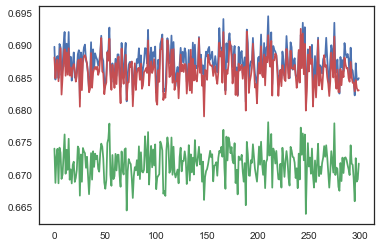

In [37]:


plt.plot(ylst[74])
plt.plot(ylst[75])
plt.plot(ylst[73])

In [24]:
np.where(np.array(siglst) > 0)

(array([ 75, 116, 157, 198], dtype=int64),)

Mean tp =  87.94666666666667 std tp =  9.73843701810283


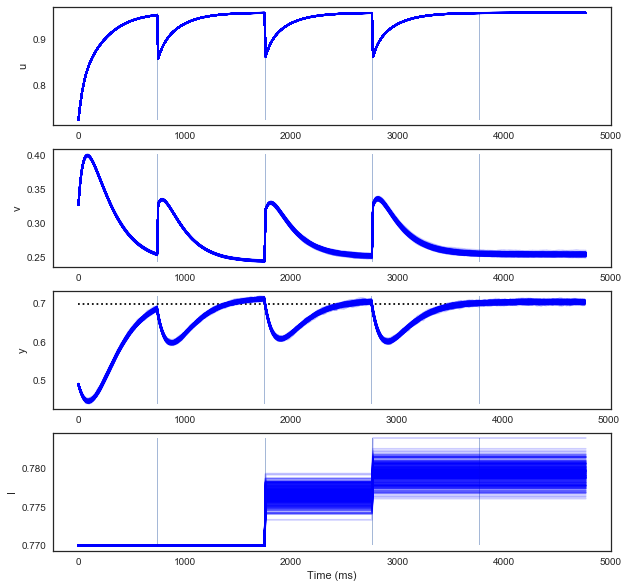

In [17]:
# Figure 3b
sigma = 0.01
I = 0.77
K = 5.0
duration = 1000

np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=4, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean tp = ', np.mean(times), 'std tp = ', np.std(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data020819_K5_00_I0_77_s0_01_400ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing parameters of the SAM

The SAM takes three free parameters, $I_0, K$, and $\sigma$. Here, we examine the RMSE of the SAM's output timing for different settings of these parameters (Figure 3c, d)

In [8]:
def find_rmse(durations, ntrials, nstages, sigma, I, K, return_inf):
    '''Do multiple simulations to find the expected mse of the given set of parameters'''
    mse_total = 0
    for k, dur in enumerate(durations):
        times = get_time_lst(ntrials=ntrials, nstages=nstages,duration=dur, 
                             sigma=sigma, K=K, initI=I)
        # Consider invalid parameters that result in infinite decision times
        if len(times) < ntrials * 0.5:
            return np.inf
        mse_total += np.sum((times * 10 - dur)**2)
    return np.sqrt(mse_total / (ntrials * len(durations)))

In [9]:
def sampling_IK_grid(sigma_lst, Ilst, Klst, durations, nstages, ntrials, return_inf=True):
    '''Perform a simulation to find the rmse of the parameters in the grid.
    sigma_lst, Ilst, Klst: list of sigma, I0 and K values to simulate.
    durations: list of ts intervals in the prior
    nstages: number of stimuli to present
    ntrials: number of trials for averaging
    return_inf: when set to True, returns Inf if any trial fails to reach threshold
    Returns a list of nI x nK arrays corresponding to each sigma'''
    # Start of main loop
    mse_arr = np.zeros((len(sigma_lst), len(Ilst), len(Klst)))
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for id_i, I in enumerate(Ilst):
            for id_k, K in enumerate(Klst):
                rmse = find_rmse(durations, ntrials=ntrials, nstages=nstages, 
                                 sigma=sigma, I=I, K=K, return_inf=return_inf)
                mse_arr[id_s, id_i, id_k] = rmse
                print('    I = %.4f, K = %.4f, RMSE = %.4f' % (I, K, rmse))
    return mse_arr

In [ ]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)
sigma_lst = [0.005] #np.linspace(0.005, 0.03, 6)

# Define the grid of I and K values
nK = 30
nI = 30
Klst = np.linspace(2, 10, nK)
Ilst = np.linspace(0.76, 0.8, nI)

# Perform the grid simulation
grid_sim_result = sampling_IK_grid(sigma_lst, Ilst, Klst, durations, nstages=4, ntrials=1000,
                                  return_inf=False)

#TODO: Deal with infinite times more properly

#scipy.io.savemat('PlotTools/IK_grid_040119_1000trialsA.mat', {'MSELST': grid_sim_result,
#                                                          'Klst': Klst,
#                                                          'Ilst': Ilst,
#                                                            'sigma_lst': sigma_lst})

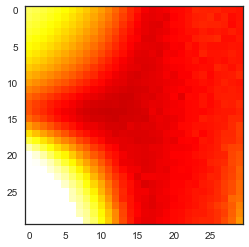

In [11]:
plt.imshow(np.log(grid_sim_result[0]), cmap='hot', vmin=3)

We now examine how the optimal values, $I_0^*$ and $K^*$ vary with $\sigma_n$ (figure 3d). For this, we do a random sampling of $(I, K)$.

In [12]:
def sampling_IK_optimization(durations, sigma_lst, nstages, ntrials, 
                             Klow, Khigh, Ilow, Ihigh, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    I_optimal = np.zeros((len(sigma_lst), maxiter))
    K_optimal = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
            Ilst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = Ilst[i]
                K = Klst[i]
                rmse = find_rmse(durations, ntrials=ntrials, nstages=nstages, 
                                 sigma=sigma, I=I, K=K, return_inf=True)
                mse_lst[i] = rmse
                #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = Ilst[argmin[0]]
            K_optimal[id_s][niter] = Kmin
            I_optimal[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return I_optimal, K_optimal

In [ ]:
durations = np.linspace(600, 1000, 5)
sigma_lst = np.linspace(0.001, 0.04, 6)
N_array = np.arange(3, 14)

Iresults = []
Kresults = []

# At the end of the simulation, Iresults and Kresults will contain the values I0* and K*
# Each is a list with len(N) np arrays (N = array representing number of stimuli)
# Each np array has shape nsigma x maxiter

for i in N_array:
    print('### Number of iterations = ', i)
    a, b = sampling_IK_optimization(durations, sigma_lst, i, ntrials=100, 
                                    Klow=1, Khigh=10, Ilow=0.77, Ihigh=0.8, 
                                    nsamples=100, maxiter=10)
    Iresults.append(a)
    Kresults.append(b)

## 1-2-Go and 1-2-3-Go

In this section, we simulate subjects' performance on the 1-2-Go and 1-2-3-Go tasks (Figure 7)

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

### Behavior fitting protocol

The protocol has two parts: (1) Fitting $(I,K)$ and (2) Fitting $\sigma$. $(I, K)$ is fitted based on the mean of the distribution, while $\sigma$ is fitted based on the standard deviation.

In [ ]:
def do_IK_fitting(subject_file, sigmaval, nsamples, ntrials, Klow, Khigh, Ilow, Ihigh,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - sigmaval: sigma value to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    I, K: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''
    #print('sigmaval = ', sigmaval)
    Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
    Ilst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        Ival = Ilst[k]
        Kval = Klst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=ntrials, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=ntrials, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Continue if there is a nan   
        error1 = (np.array(prod_time_lst) * 10 - target_time1) ** 2
        error2 = (np.array(prod_time_lst2) * 10 - target_time2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
        # Error function to minimize
            error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) +\
                    np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, sigma = %f, error = %f' %(Ival, Kval, sigmaval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal (I, K) = ', Ilst[idx], Klst[idx])
    return Ilst[idx], Klst[idx]

In [ ]:
def do_sigma_fitting(subject_file, Ival, Kval, nsamples, ntrials, 
                     low, high, print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - Ival, Kval: I and K values to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    sigma: the optimal sigma to minimize the mse between the std simulated times
    and the std behavioral times of the subject'''

    sigmalst = np.linspace(low, high, nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_std1 = stdtp_in[:,0]
    target_std2 = stdtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        sigmaval = sigmalst[k]
        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))
            
        # Continue if there is a nan   
        error1 = (np.array(prod_var_lst) * 10 - target_std1) ** 2
        error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
            # Error function to minimize
            error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) +\
                    np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)
        
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, sigma = %f, error = %f' %(Ival, Kval, sigmaval, error))
            #print(np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2))
            #print(np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal sigma = ', sigmalst[idx], 'error =', error)
    #print(sum(target_std1))
    #print(sum(target_std2))
    return sigmalst[idx]

In [ ]:
def subject_fitting(subject_file, nsamples, nsamples2, ntrials,
                    Klow, Khigh, Ilow, Ihigh, 
                    sigmalow, sigmahigh, print_every=10, niter=5, sigma_init=0.02):
    '''Performs fitting of sigma, I, K for a given subject file,
    Inputs:
    - subject_file: name of .mat behavior file,
    - nsamples: number of I-K combinations to sample
    - nsamples2: number of sigma values to sample
    - ntrials: number of trials for averaging
    - Klow, Khigh, Ilow, Ihigh, sigmalow, sigmahigh: specify the range of K, I and sigma
    - print_every: to print a line every x combinations
    - niter: how many times to alternate between IK sampling and sigma sampling
    - sigma_init: initial value of sigma
    Returns the fitted combination (sigma, I, K)'''
    sigmaval = sigma_init
    for i in range(niter):
        Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, ntrials=ntrials,
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
        sigmaval = do_sigma_fitting(subject_file, Ival=Ival, Kval=Kval, nsamples=nsamples2, ntrials=ntrials,
                                    low=sigmalow, high=sigmahigh, print_every=print_every)
    # One last round of IK fitting
    Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, ntrials=ntrials,
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
    return sigmaval, Ival, Kval
    
    

In [ ]:
# Behavior files of subjects to load from
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat']

np.random.seed(123)

combi_rep = []

# At the end of the fitting procedure, the fitted values are stored in three arrays,
# sigmas, Iarr, and Karr. The order of the values correspond to the order of all_subject_files
tstart = time.time()
for i in range(9):
    combi_collection = []
    for subject_file in all_subject_files:
        print(' ********* Doing subject file %s ************' % subject_file)
        combi = subject_fitting(subject_file, nsamples=100, nsamples2=100, ntrials=100, Klow=1.0, Khigh=8.0, 
                                Ilow=0.77, Ihigh=0.79, sigmalow=0.005, sigmahigh=0.04, print_every=50)
        combi_collection.append(combi)
    combi_rep.append(combi_collection)
    
tend = time.time()

# Collate results
combi_arr = np.array(combi_collection)
sigmas = combi_arr[:,0]
Iarr = combi_arr[:,1]
Karr = combi_arr[:,2]


# Save results
#scipy.io.savemat('PlotTools/IK_subject_fit_040219_thres0_7_constant_stage0_750ms_5reps.mat', 
#                 {'combi_rep': np.array(combi_rep), 'all_subject_files': all_subject_files})

After fitting, we compare model fit and actual subject behavior (figure 7b).

In [ ]:
# Load data for subject
subjectID = 0 # Refer to `all_subject_files' to see which subject is being shown
subject_file = all_subject_files[subjectID]

np.random.seed(111)

# Simulate circuit model behavior based on fitted values
sigma_val = sigmas[subjectID]
I_val = Iarr[subjectID]
K_val = Karr[subjectID]

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigma_val, K=K_val, initI=I_val)
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, dur in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigma_val, K=K_val, initI=I_val)
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))



In [ ]:
scipy.io.savemat('PlotTools/GB_sim_results_021119_with_warmup.mat', 
                 {'durations': durations, 'mtp_in': mtp_in, 'prod_time_lst': prod_time_lst,
                 'prod_time_lst2': prod_time_lst2, 'prod_var_lst': prod_var_lst,
                 'prod_var_lst2': prod_var_lst2, 'stdtp_in': stdtp_in, 'tss': tss})

### Model and subject BIAS, VAR, and RMSE

Finally, we visualize the model and subjects' BIAS and VAR (figure 7c).

In [ ]:
collated_bias_var = []

for i in range(len(all_subject_files)):
    print('Doing subject #%d of %d...' % (i + 1, len(all_subject_files)))
    # Load data for subject
    subject_file = all_subject_files[i]
    sigmaval = combi_arr[i,0]
    Ival = combi_arr[i,1]
    Kval = combi_arr[i,2]

    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

    #1,2,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst.append(np.mean(times))
        prod_var_lst.append(np.std(times))

    #1,2,3,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst2.append(np.mean(times))
        prod_var_lst2.append(np.std(times))

    # Bias
    bias_model1 = np.sum((np.array(prod_time_lst) * 10 - tss.T)**2) / len(tss)
    bias_subject1 = np.sum((target_time1 - tss.T)**2) / len(tss)
    bias_model2 = np.sum((np.array(prod_time_lst2) * 10 - tss.T)**2) / len(tss)
    bias_subject2 = np.sum((target_time2 - tss.T)**2) / len(tss)

    # Variance
    var_model1 = np.sum((np.array(prod_var_lst) * 10)**2) / len(tss)
    var_subject1 = np.sum(stdtp_in[:,0]**2) / len(tss)
    var_model2 = np.sum((np.array(prod_var_lst2) * 10)**2) / len(tss)
    var_subject2 = np.sum(stdtp_in[:,1]**2) / len(tss)
    
    # Collate
    collated_bias_var.append((bias_model1, bias_subject1, bias_model2, bias_subject2,
                             var_model1, var_subject1, var_model2, var_subject2))

collated_bias_var = np.sqrt(np.array(collated_bias_var))

In [ ]:
# Plot bias and variance
plt.plot(collated_bias_var[:,0], collated_bias_var[:,1], 'ro', label='Bias1')
plt.plot(collated_bias_var[:,2], collated_bias_var[:,3], 'bo', label='Bias2')
plt.plot(collated_bias_var[:,4], collated_bias_var[:,5], 'rx', label='Var1')
plt.plot(collated_bias_var[:,6], collated_bias_var[:,7], 'bx', label='Var2')
plt.plot([5,150], [5, 150])
plt.legend()

In [ ]:
# Save collated bias and variance
suffix = '021119_thres0_7_constant_stage0_750ms_Krange1to8_Irange77to79_sigma005to04.mat'
#scipy.io.savemat('PlotTools/IK_subject_fit_' + suffix, 
#                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
#scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
#                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst})
#scipy.io.savemat('PlotTools/biasvar_' + suffix, 
#                 {'collated_bias_var': collated_bias_var, 'all_subject_files': all_subject_files})

In [ ]:
suffix = '020719_thres0_7_constant_stage0_750ms_optimized3_Krange1to7B.mat'

#scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
#                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst,
#                'nstages': np.arange(3, 14), 'PARAMS': PARAMS_DICT})
